In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


%matplotlib inline

In [2]:
file_name = "airbnb_session_data.txt"
df = pd.read_csv(file_name, delimiter ='|', parse_dates=['ds','ts_max','ts_min','next_ts_max','next_ts_min'])

In [3]:
boolean_columns = [
    'did_search', 
    'sent_message',
    'sent_booking_request', 
    'next_did_search',
    'next_sent_message',
    'next_sent_booking_request'
]
df[boolean_columns] = df[boolean_columns].astype(bool)

In [4]:
# session duration is in Minutes
df['session_duration'] = (df['ts_max'] - df['ts_min']) / np.timedelta64(1, 'm')
df['next_session_duration'] = (df['next_ts_max'] - df['next_ts_min']) / np.timedelta64(1, 'm')

df.columns

Index(['id_visitor', 'id_session', 'dim_session_number', 'dim_user_agent',
       'dim_device_app_combo', 'ds', 'ts_min', 'ts_max', 'did_search',
       'sent_message', 'sent_booking_request', 'next_id_session',
       'next_dim_session_number', 'next_dim_user_agent',
       'next_dim_device_app_combo', 'next_ds', 'next_ts_min', 'next_ts_max',
       'next_did_search', 'next_sent_message', 'next_sent_booking_request',
       'session_duration', 'next_session_duration'],
      dtype='object')

In [5]:
session_df = df[['dim_session_number', 
                 'session_duration',
                 'next_session_duration',
                 'did_search', 
                 'sent_message',
                 'sent_booking_request',
                 'next_id_session',
                 'next_did_search',
                 'next_sent_message',
                 'next_sent_booking_request',
                 'dim_device_app_combo',
                 'id_visitor'
                ]]

session_df.tail(3)

,dim_session_number,session_duration,next_session_duration,did_search,sent_message,sent_booking_request,next_id_session,next_did_search,next_sent_message,next_sent_booking_request,dim_device_app_combo,id_visitor
7753,5,10.700000,0.483333,True,False,False,7ad89a28468df5bab4c4244588806960,False,False,False,iPad - Web,1414271365_EuFmeZ+vsDuryP8F
7754,6,0.483333,NaN,False,False,False,NaN,True,True,True,iPad - Web,1414271365_EuFmeZ+vsDuryP8F
7755,1,0.000000,NaN,False,False,False,NaN,True,True,True,Desktop - Chrome,1416012256_dB6ft6mhjVRXX48c


In [6]:
session_df.loc[:, 'device'] = session_df['dim_device_app_combo'].map(lambda x: x.split('-')[0])
session_df.loc[:, 'app'] = session_df['dim_device_app_combo'].map(lambda x: x.split('-')[1])

session_df.loc[:, 'has_next_session'] = pd.notnull(df['next_id_session'])

session_df.tail(3)

/usr/local/lib/python3.4/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,dim_session_number,session_duration,next_session_duration,did_search,sent_message,sent_booking_request,next_id_session,next_did_search,next_sent_message,next_sent_booking_request,dim_device_app_combo,id_visitor,device,app,has_next_session
7753,5,10.700000,0.483333,True,False,False,7ad89a28468df5bab4c4244588806960,False,False,False,iPad - Web,1414271365_EuFmeZ+vsDuryP8F,iPad,Web,True
7754,6,0.483333,NaN,False,False,False,NaN,True,True,True,iPad - Web,1414271365_EuFmeZ+vsDuryP8F,iPad,Web,False
7755,1,0.000000,NaN,False,False,False,NaN,True,True,True,Desktop - Chrome,1416012256_dB6ft6mhjVRXX48c,Desktop,Chrome,False


In [7]:
groupby_device = session_df.groupby(['device'])
groupby_app = session_df.groupby(['app'])
groupby_app_device = session_df.groupby(['dim_device_app_combo'])
percent_function = lambda x: np.sum(x) / len(x)

agg_functions = {"count": np.sum, "rate": percent_function}
stats_functions = {'mean': np.mean, 'std': np.std}

agg = {'sent_booking_request':agg_functions,\
       'sent_message':agg_functions,\
       'did_search':agg_functions,\
       'has_next_session': agg_functions,\
       'dim_session_number': stats_functions,\
       'session_duration': stats_functions,\
       'device': {'count': len},\
       'app': {'count': len},\
       'id_visitor': {'uniq_count': lambda x: len(set(x))},\
      }

In [8]:
device_df = groupby_device.agg(agg)
device_df.columns = ['_'.join(col).strip() for col in device_df.columns.values]
device_df.reset_index(level=0, inplace=True)
device_df


,device,sent_booking_request_rate,sent_booking_request_count,has_next_session_rate,has_next_session_count,sent_message_rate,sent_message_count,dim_session_number_std,dim_session_number_mean,app_count,session_duration_std,session_duration_mean,device_count,did_search_rate,did_search_count,id_visitor_uniq_count
0,Android Phone,0.009449,6,0.962205,611,0.182677,116,43.168884,52.162205,635,22.002976,11.491601,635,0.129134,82,38
1,Android Tablet,0.003175,1,0.961905,303,0.330159,104,108.861701,142.736508,315,10.811998,7.257354,315,0.060317,19,16
2,Desktop,0.044538,106,0.837815,1994,0.242857,578,78.442936,50.457983,2380,21.075992,12.585840,2380,0.297059,707,427
3,Other,0.003745,1,0.951311,254,0.022472,6,77.308701,67.329588,267,10.755812,3.103246,267,0.018727,5,48
4,Unknown,0.000000,0,0.885246,108,0.000000,0,21.453575,16.286885,122,5.498257,2.630055,122,0.040984,5,41
5,iPad,0.016854,9,0.852060,455,0.131086,70,34.456582,27.159176,534,26.951990,13.476654,534,0.279026,149,97
6,iPhone,0.006280,22,0.970882,3401,0.115615,405,161.646408,150.772766,3503,33.440453,10.120073,3503,0.076791,269,141


In [9]:
app_df = groupby_app.agg(agg)
app_df.columns = ['_'.join(col).strip() for col in app_df.columns.values]
app_df.reset_index(level=0, inplace=True)
app_df.tail(10)

,app,sent_booking_request_rate,sent_booking_request_count,has_next_session_rate,has_next_session_count,sent_message_rate,sent_message_count,dim_session_number_std,dim_session_number_mean,app_count,session_duration_std,session_duration_mean,device_count,did_search_rate,did_search_count,id_visitor_uniq_count
0,Android,0.012903,6,0.974194,453,0.193548,90,35.047692,46.281720,465,24.733499,14.224086,465,0.176344,82,19
1,Chrome,0.047417,56,0.863675,1020,0.230313,272,77.628471,49.279424,1181,18.670673,11.133460,1181,0.270110,319,191
2,Firefox,0.061162,20,0.840979,275,0.229358,75,46.802021,29.758410,327,28.509182,17.280326,327,0.382263,125,72
3,IE,0.025641,11,0.848485,364,0.310023,133,100.233808,78.037296,429,17.419504,11.143046,429,0.216783,93,78
4,Moweb,0.003200,2,0.924800,578,0.080000,50,161.925015,116.198400,625,15.387098,3.363467,625,0.016000,10,111
5,Other,0.003745,1,0.951311,254,0.022472,6,77.308701,67.329588,267,10.755812,3.103246,267,0.018727,5,48
6,Safari,0.042889,19,0.756208,335,0.221219,98,67.522461,42.171558,443,23.230907,14.389729,443,0.383747,170,127
7,Web,0.003959,7,0.928733,1642,0.088235,156,145.849763,128.363122,1768,29.807038,8.766610,1768,0.072964,129,202
8,iOS,0.010218,23,0.979565,2205,0.177255,399,151.722295,134.003110,2251,34.074856,12.587968,2251,0.134607,303,71


In [10]:
app_device_df = groupby_app_device.agg(agg)
app_device_df.columns = ['_'.join(col).strip() for col in app_device_df.columns.values]
app_device_df.reset_index(level=1, inplace=True)
app_device_df.loc[:, 'device'] = app_device_df['dim_device_app_combo'].map(lambda x: x.split('-')[0])
app_device_df.loc[:, 'app'] = app_device_df['dim_device_app_combo'].map(lambda x: x.split('-')[1])
app_device_df

,dim_device_app_combo,sent_booking_request_rate,sent_booking_request_count,has_next_session_rate,has_next_session_count,sent_message_rate,sent_message_count,dim_session_number_std,dim_session_number_mean,app_count,session_duration_std,session_duration_mean,device_count,did_search_rate,did_search_count,id_visitor_uniq_count,device,app
0,Android Phone - Android,0.013304,6,0.977827,441,0.192905,87,35.290570,47.011086,451,25.005423,14.277162,451,0.179601,81,18,Android Phone,Android
1,Android Phone - Moweb,0.000000,0,0.888889,64,0.319444,23,46.588189,55.361111,72,9.240396,5.254398,72,0.000000,0,20,Android Phone,Moweb
2,Android Phone - Web,0.000000,0,0.946429,106,0.053571,6,61.155423,70.848214,112,8.157488,4.284375,112,0.008929,1,25,Android Phone,Web
3,Android Tablet - Android,0.000000,0,0.857143,12,0.214286,3,10.885266,22.785714,14,13.688600,12.514286,14,0.071429,1,2,Android Tablet,Android
4,Android Tablet - Moweb,0.000000,0,1.000000,2,0.000000,0,0.707107,22.500000,2,1.838478,5.216667,2,0.000000,0,1,Android Tablet,Moweb
5,Android Tablet - Web,0.003344,1,0.966555,289,0.337793,101,108.016864,149.157191,299,10.658787,7.024861,299,0.060201,18,15,Android Tablet,Web
6,Desktop - Chrome,0.047417,56,0.863675,1020,0.230313,272,77.628471,49.279424,1181,18.670673,11.133460,1181,0.270110,319,191,Desktop,Chrome
7,Desktop - Firefox,0.061162,20,0.840979,275,0.229358,75,46.802021,29.758410,327,28.509182,17.280326,327,0.382263,125,72,Desktop,Firefox
8,Desktop - IE,0.025641,11,0.848485,364,0.310023,133,100.233808,78.037296,429,17.419504,11.143046,429,0.216783,93,78,Desktop,IE
9,Desktop - Safari,0.042889,19,0.756208,335,0.221219,98,67.522461,42.171558,443,23.230907,14.389729,443,0.383747,170,127,Desktop,Safari


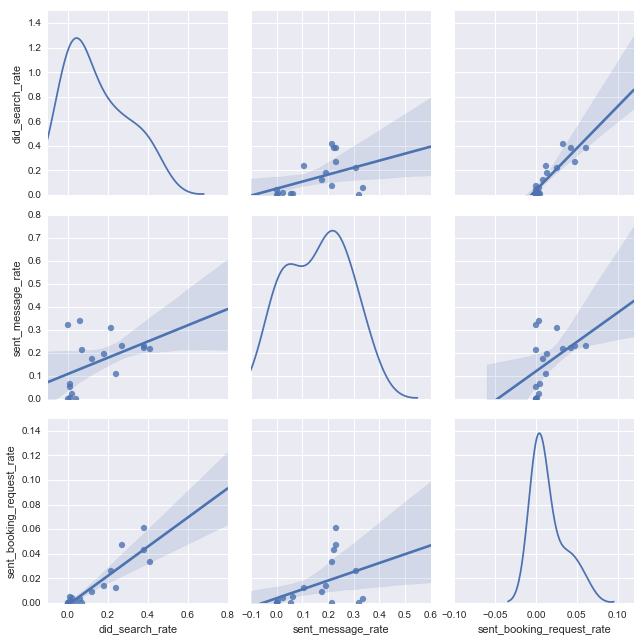

In [95]:
plot_vars = [
    'has_next_session_rate',
    'did_search_rate',
    'sent_message_rate',
    'sent_booking_request_rate',
]

plots = sb.pairplot(app_device_df, 
                    vars=plot_vars, 
                    diag_kind='kde', 
                    kind='reg', 
                    size=3,
                    plot_kws={'scatter_kws':{"s": 40}}
                   )
plots.set(ylim=(0, None), xlim=(0,None))


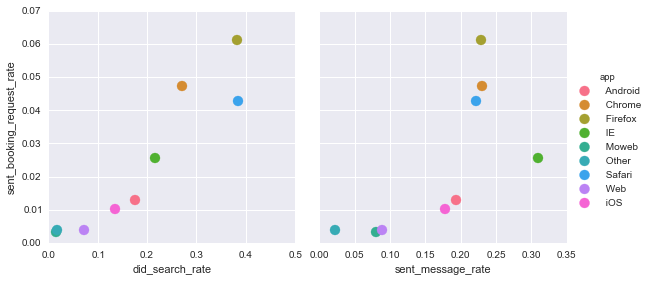

In [103]:
x_vars = [
    'did_search_rate',
    'sent_message_rate'
]

sb.pairplot(app_df, 
            x_vars=x_vars, 
            y_vars='sent_booking_request_rate', 
            hue='app', 
            size=4, 
            plot_kws={"s": 100}
           ).set(ylim=(0, None), xlim=(0,None))

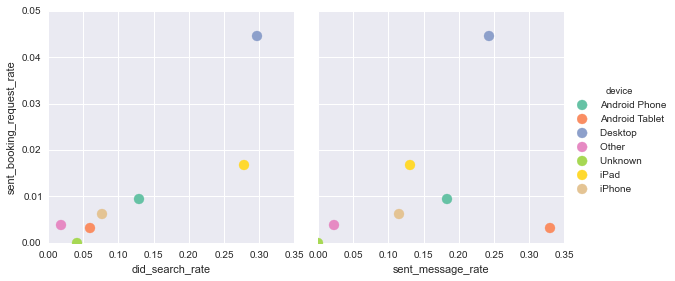

In [105]:
sb.pairplot(device_df,
            x_vars=x_vars,
            y_vars='sent_booking_request_rate',
            hue='device',
            size=4,
            palette="Set2",
            plot_kws={"s": 100}
           ).set(ylim=(0, None), xlim=(0,None))

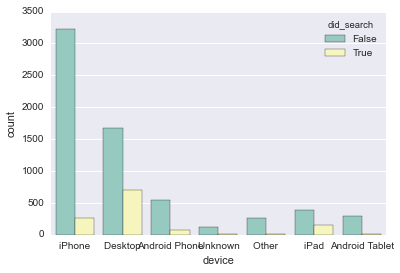

In [100]:
device_count_plots = sb.countplot(x="device", hue='did_search',palette="Set3", data=session_df)

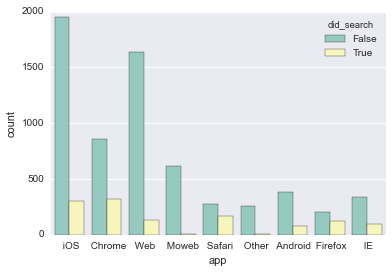

In [99]:
app_count_plots = sb.countplot(x="app", hue='did_search',palette="Set3",data=session_df)

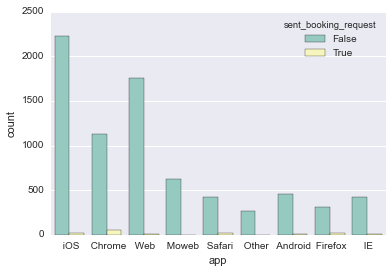

In [107]:
app_count_plots = sb.countplot(x="app", hue='sent_booking_request',palette="Set3",data=session_df)

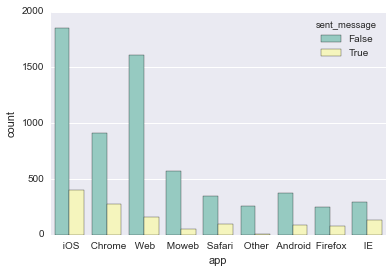

In [108]:
app_count_plots = sb.countplot(x="app", hue='sent_message',palette="Set3",data=session_df)

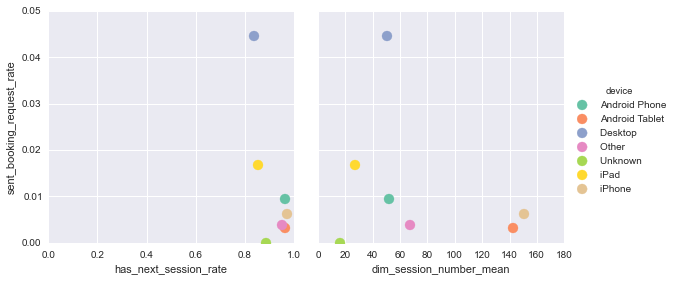

In [110]:
sb.pairplot(device_df,
            x_vars=['has_next_session_rate', 'dim_session_number_mean'],
            y_vars='sent_booking_request_rate',
            hue='device',
            size=4,
            palette="Set2",
            plot_kws={"s": 100}
           ).set(ylim=(0, None), xlim=(0,None))